# Day 1: Deep Foundations - Comprehensive Exercise

**Time:** 3-4 hours  
**Prerequisites:** Downloaded Sentinel-1 GRD data (or will use synthetic data)

This exercise verifies your understanding of:
1. Autoencoder theory
2. SAR physics
3. Loss functions
4. Data preprocessing

---

## Setup and Imports

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import uniform_filter
from scipy.stats import gamma as gamma_dist
from pathlib import Path
from tqdm.notebook import tqdm
from glob import glob


project_root = Path("D:/Projects/CNNAutoencoderProject")
print(project_root)
checkpointdir = project_root / "checkpoints"
checkpointdir.mkdir(exist_ok=True)
print(checkpointdir)
try:
    import rasterio
    HAS_RASTERIO = True
except ImportError:
    HAS_RASTERIO = False
    print("rasterio not installed - will use synthetic data")

# Configure matplotlib
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

D:\Projects\CNNAutoencoderProject
D:\Projects\CNNAutoencoderProject\checkpoints
Setup complete!


---

# Part 1: Theory Questions (30 minutes)

Write complete answers demonstrating understanding, not just keywords.  
Each answer should be 3-6 sentences minimum.

## Question 1: Information Bottleneck

Your autoencoder compresses 256×256×1 images (65,536 dimensions) to 16×16×64 latent (16,384 dimensions), a 4× reduction.

**a)** Explain why this forces the encoder to learn useful features rather than memorizing the input.

**b)** If you doubled the latent channels to 128, would reconstruction improve? What if you doubled it to 256? Is there a point of diminishing returns?

**c)** How does the concept of "intrinsic dimensionality" relate to choosing the appropriate latent size?

### Your Answer:

*Write your answer here (6-10 sentences total covering a, b, c)*

**a)** 

**b)** 

**c)** 


## Question 2: SAR Physics

You're examining a Sentinel-1 image of a coastal area containing:
- Sandy beach (wet near water, dry further up)
- Breakwater (concrete wall extending into sea)
- Small harbor with boats
- Calm harbor water vs. rough open ocean

**a)** Describe the expected relative brightness of each feature and explain the physical mechanism causing each appearance.

**b)** How would the appearance change if you compared images from:
- Morning vs. evening (hint: wind patterns)
- Summer vs. winter (hint: water temperature affects roughness)

### Your Answer:

*Write your answer here (8-12 sentences covering all features and temporal variations)*

**a)** Feature brightness predictions:

**b)** Temporal variations:


## Question 3: Speckle

Your SAR image has approximately 4 looks (multi-looking), meaning CV ≈ 0.5.

**a)** Explain what "4 looks" means physically in terms of resolution and speckle reduction.

**b)** Your autoencoder reconstruction has CV ≈ 0.35. Is this desirable? Under what circumstances would this be a problem?

**c)** Design an experiment to determine whether your autoencoder is "removing speckle" or "removing texture." What metrics would you use?

### Your Answer:

*Write your answer here (8-12 sentences covering a, b, c)*

**a)** 

**b)** 

**c)** 


## Question 4: Loss Functions

You train two models:
- Model A: MSE loss only
- Model B: MSE + 0.2 × (1 - SSIM)

After training, you observe:
- Model A: PSNR = 32 dB, SSIM = 0.82
- Model B: PSNR = 31 dB, SSIM = 0.89

**a)** Explain why Model B has lower PSNR but higher SSIM.

**b)** Which model produces sharper reconstructions? Why?

**c)** For a downstream task of ship detection, which model would you prefer? What about for visual interpretation by an analyst?

### Your Answer:

*Write your answer here (6-10 sentences covering a, b, c)*

**a)** 

**b)** 

**c)** 


## Question 5: Preprocessing

Your raw SAR image has:
- Intensity range: [1e-6, 500]
- Mean intensity: 0.08
- Many zero-value pixels (nodata)

**a)** Step through your preprocessing pipeline and explain what each step does and why it's necessary.

**b)** You chose clip bounds of [-25, +5] dB. What percentage of pixels are being clipped (approximately)? Is this acceptable?

**c)** A colleague suggests normalizing each image independently to [0,1]. Explain why this is problematic for training an autoencoder.

### Your Answer:

*Write your answer here (8-12 sentences covering a, b, c)*

**a)** 

**b)** 

**c)** 


---

# Part 2: SAR Data Analysis (45 minutes)

In this section, you'll load and analyze SAR data to understand its statistical properties.

## 2.1 Load SAR Image

First, let's set up functions to load data. If you have real Sentinel-1 data, update the path. Otherwise, we'll generate synthetic data.

In [5]:
def load_sar_image(tiff_path):
    """Load Sentinel-1 GeoTIFF."""
    with rasterio.open(tiff_path) as src:
        image = src.read(1).astype(np.float32)
    return image


In [6]:
TIFF_PATH = r"D:\Projects\CNNAutoencoderProject\data\raw\*.tiff"

files = glob(TIFF_PATH)
print(f"Found {len(files)} files:")
for f in files:
    print(f"  {f}")

Found 2 files:
  D:\Projects\CNNAutoencoderProject\data\raw\s1c-iw-grd-vh-20260117t052634-20260117t052659-005939-00be9c-002.tiff
  D:\Projects\CNNAutoencoderProject\data\raw\s1c-iw-grd-vv-20260117t052634-20260117t052659-005939-00be9c-001.tiff


In [7]:

# Try to load real data, fall back to synthetic
tiff_files = glob(TIFF_PATH, recursive=True)

if tiff_files and HAS_RASTERIO:
    print(f"Found {len(tiff_files)} SAR file(s)")
    print(f"Loading: {tiff_files[0]}")
    image = load_sar_image(tiff_files[0])
    clean_image = None  # We don't have ground truth for real data
    DATA_SOURCE = "real"

print(f"\nImage shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print(f"Value range: [{image.min():.6f}, {image.max():.2f}]")

Found 2 SAR file(s)
Loading: D:\Projects\CNNAutoencoderProject\data\raw\s1c-iw-grd-vh-20260117t052634-20260117t052659-005939-00be9c-002.tiff

Image shape: (16704, 26101)
Image dtype: float32
Value range: [0.000000, 16201.00]


## 2.2 Compute Comprehensive Statistics

**Exercise:** Complete the `analyze_sar_statistics` function to compute statistics in both linear and dB domains.

In [8]:
def analyze_sar_statistics(image):
    """
    Compute comprehensive statistics for SAR image.
    
    Returns a dictionary containing:
    - Linear domain statistics
    - dB domain statistics  
    - Percentiles for clipping decisions
    - Estimated number of looks from CV
    """
    # Handle invalid values
    image_valid = np.where(image > 0, image, np.nan)
    image_clean = image_valid[~np.isnan(image_valid)]
    
    # =========================================
    # LINEAR DOMAIN STATISTICS
    # =========================================
    linear_stats = {
        'min': float(np.min(image_clean)),
        'max': float(np.max(image_clean)),
        'mean': float(np.mean(image_clean)),
        'std': float(np.std(image_clean)),
        'median': float(np.median(image_clean)),
    }
    
    # Dynamic range in dB
    linear_stats['dynamic_range_dB'] = 10 * np.log10(
        linear_stats['max'] / linear_stats['min']
    )
    
    # =========================================
    # CONVERT TO dB
    # =========================================
    image_db = 10 * np.log10(image_clean)
    
    db_stats = {
        'min': float(np.min(image_db)),
        'max': float(np.max(image_db)),
        'mean': float(np.mean(image_db)),
        'std': float(np.std(image_db)),
        'median': float(np.median(image_db)),
    }
    
    # =========================================
    # PERCENTILES (for clipping decisions)
    # =========================================
    percentiles = {
        'p0.5': float(np.percentile(image_db, 0.5)),
        'p1': float(np.percentile(image_db, 1)),
        'p5': float(np.percentile(image_db, 5)),
        'p50': float(np.percentile(image_db, 50)),
        'p95': float(np.percentile(image_db, 95)),
        'p99': float(np.percentile(image_db, 99)),
        'p99.5': float(np.percentile(image_db, 99.5)),
    }
    
    # =========================================
    # ESTIMATE NUMBER OF LOOKS
    # For gamma-distributed intensity: CV = 1/sqrt(L)
    # So L = 1/CV²
    # =========================================
    cv = linear_stats['std'] / linear_stats['mean']
    estimated_looks = 1 / (cv ** 2)
    
    # =========================================
    # COUNT INVALID PIXELS
    # =========================================
    n_total = image.size
    n_invalid = np.sum(image <= 0)
    
    return {
        'linear': linear_stats,
        'dB': db_stats,
        'percentiles': percentiles,
        'estimated_looks': estimated_looks,
        'coefficient_of_variation': cv,
        'invalid_pixel_fraction': n_invalid / n_total,
    }

In [9]:
# Run the analysis
stats = analyze_sar_statistics(image)

print("=" * 60)
print("SAR IMAGE STATISTICS")
print("=" * 60)

print("\n--- Linear Domain ---")
for key, val in stats['linear'].items():
    print(f"  {key}: {val:.6f}")

print("\n--- dB Domain ---")
for key, val in stats['dB'].items():
    print(f"  {key}: {val:.2f} dB")

print("\n--- Percentiles (dB) ---")
for key, val in stats['percentiles'].items():
    print(f"  {key}: {val:.2f} dB")

print("\n--- Speckle Analysis ---")
print(f"  Coefficient of Variation: {stats['coefficient_of_variation']:.3f}")
print(f"  Estimated Number of Looks: {stats['estimated_looks']:.2f}")
print(f"  Theoretical CV for 4 looks: {1/np.sqrt(4):.3f}")

print("\n--- Data Quality ---")
print(f"  Invalid pixel fraction: {100*stats['invalid_pixel_fraction']:.2f}%")

SAR IMAGE STATISTICS

--- Linear Domain ---
  min: 2.000000
  max: 16201.000000
  mean: 90.855888
  std: 47.226131
  median: 83.000000
  dynamic_range_dB: 39.085118

--- dB Domain ---
  min: 3.01 dB
  max: 42.10 dB
  mean: 19.15 dB
  std: 1.96 dB
  median: 19.19 dB

--- Percentiles (dB) ---
  p0.5: 12.04 dB
  p1: 13.01 dB
  p5: 16.02 dB
  p50: 19.19 dB
  p95: 22.15 dB
  p99: 23.80 dB
  p99.5: 24.55 dB

--- Speckle Analysis ---
  Coefficient of Variation: 0.520
  Estimated Number of Looks: 3.70
  Theoretical CV for 4 looks: 0.500

--- Data Quality ---
  Invalid pixel fraction: 3.57%


In [10]:
np.save(checkpointdir / "analysisSAR1.npy", stats)

## 2.3 Local Coefficient of Variation

**Exercise:** Implement a function to compute local CV, which helps identify homogeneous regions and analyze speckle.

In [11]:
def compute_local_cv(image, window_size=32):
    """
    Compute local coefficient of variation.
    
    CV = local_std / local_mean
    
    For pure speckle in homogeneous regions: CV ≈ 1/sqrt(L)
    where L is the number of looks.
    
    Args:
        image: SAR intensity image (linear domain)
        window_size: Size of local window
        
    Returns:
        cv_map: Local CV at each pixel
    """
    # Ensure positive values
    image_safe = np.maximum(image, 1e-10)
    
    # Local mean using uniform filter
    local_mean = uniform_filter(image_safe, size=window_size)
    
    # Local variance = E[X²] - E[X]²
    local_sq_mean = uniform_filter(image_safe**2, size=window_size)
    local_var = local_sq_mean - local_mean**2
    local_var = np.maximum(local_var, 0)  # Numerical stability
    
    # Local std and CV
    local_std = np.sqrt(local_var)
    local_cv = local_std / (local_mean + 1e-10)
    
    return local_cv

In [12]:
# Compute local CV map
cv_map = compute_local_cv(image, window_size=32)

print(f"Local CV statistics:")
print(f"  Mean: {cv_map.mean():.3f}")
print(f"  Std: {cv_map.std():.3f}")
print(f"  Min: {cv_map.min():.3f}")
print(f"  Max: {cv_map.max():.3f}")

Local CV statistics:
  Mean: 0.341
  Std: 0.170
  Min: 0.000
  Max: 31.984


In [13]:
np.save(checkpointdir / "cvmap", cv_map)

## 2.4 Comprehensive Visualization

**Exercise:** Create a visualization showing the image in different representations.

In [14]:
def visualize_sar_image(image, cv_map=None, save_path=None):
    """
    Create comprehensive visualization of SAR image.
    
    Shows:
    - Raw linear image (two stretches)
    - dB image with percentile stretch
    - Histogram of dB values
    - Local CV map (for speckle analysis)
    - Zoomed region showing speckle
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Handle invalid values
    image_safe = np.maximum(image, 1e-10)
    image_db = 10 * np.log10(image_safe)
    
    # 1. Raw linear - full range (will look bad)
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Linear (full range - note poor contrast)')
    axes[0, 0].axis('off')
    
    # 2. Raw linear - percentile stretch
    vmin_lin = np.percentile(image[image > 0], 2)
    vmax_lin = np.percentile(image[image > 0], 98)
    axes[0, 1].imshow(image, cmap='gray', vmin=vmin_lin, vmax=vmax_lin)
    axes[0, 1].set_title('Linear (2-98 percentile stretch)')
    axes[0, 1].axis('off')
    
    # 3. dB image - percentile stretch
    vmin_db = np.percentile(image_db, 1)
    vmax_db = np.percentile(image_db, 99)
    axes[0, 2].imshow(image_db, cmap='gray', vmin=vmin_db, vmax=vmax_db)
    axes[0, 2].set_title(f'dB scale [{vmin_db:.1f}, {vmax_db:.1f}]')
    axes[0, 2].axis('off')
    
    # 4. Histogram of dB values
    axes[1, 0].hist(image_db.flatten(), bins=200, density=True, alpha=0.7, color='steelblue')
    axes[1, 0].axvline(vmin_db, color='r', linestyle='--', label=f'1st pct: {vmin_db:.1f}')
    axes[1, 0].axvline(vmax_db, color='r', linestyle='--', label=f'99th pct: {vmax_db:.1f}')
    axes[1, 0].set_xlabel('Value (dB)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Histogram of dB values')
    axes[1, 0].legend()
    
    # 5. Local CV map (speckle analysis)
    if cv_map is None:
        cv_map = compute_local_cv(image, window_size=32)
    im = axes[1, 1].imshow(cv_map, cmap='viridis', vmin=0, vmax=1.5)
    axes[1, 1].set_title('Local CV (window=32)')
    plt.colorbar(im, ax=axes[1, 1], fraction=0.046)
    axes[1, 1].axis('off')
    
    # 6. Zoomed region showing speckle texture
    h, w = image.shape
    zoom_size = min(256, h//4, w//4)
    y_start = h // 2 - zoom_size // 2
    x_start = w // 2 - zoom_size // 2
    zoom = image_db[y_start:y_start+zoom_size, x_start:x_start+zoom_size]
    axes[1, 2].imshow(zoom, cmap='gray', vmin=vmin_db, vmax=vmax_db)
    axes[1, 2].set_title('Zoomed center region (notice speckle texture)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(project_root / "data" / "images" / save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    plt.close(fig)
    return fig

In [15]:
print(f"Original size : {image.shape}")
h, w = image.shape
crop_size = 4096
y_start = h // 2 - crop_size // 2
x_start = w // 2 - crop_size // 2

image_cropped = image[y_start: y_start + crop_size, x_start: x_start + crop_size]

print(f"Cropped Size: {image_cropped.shape}")


Original size : (16704, 26101)
Cropped Size: (4096, 4096)


In [16]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

loading from checkpoint ...
Saved visualization to sar_visualization_20260118_072126.png


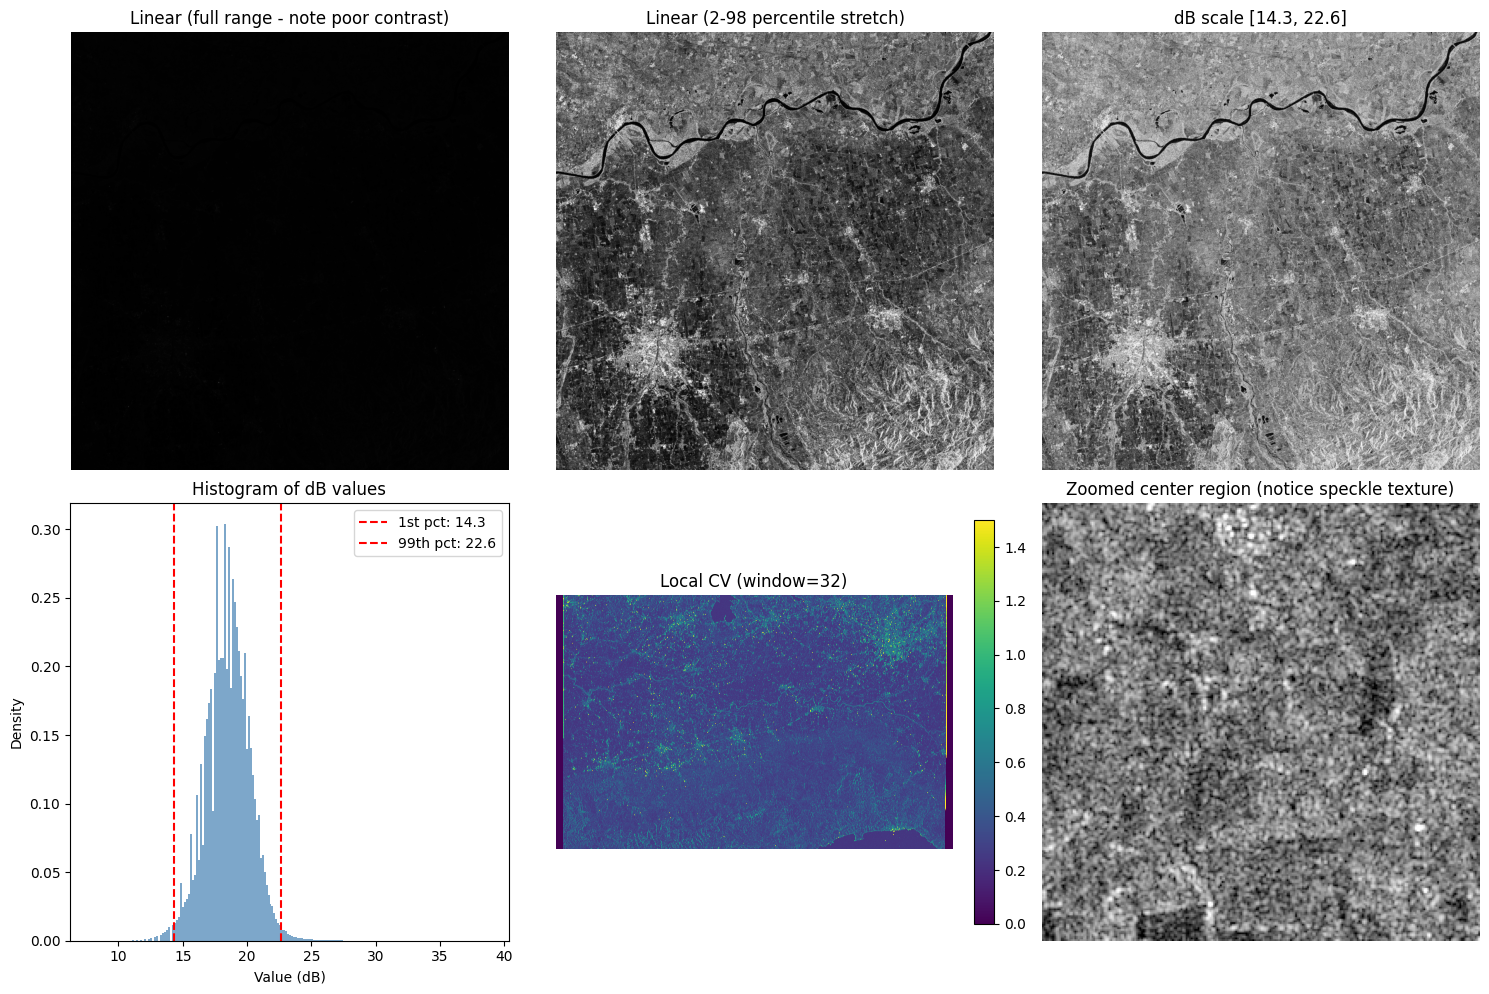

In [17]:
# Create visualization
cv_map_file = checkpointdir / "cvmap.npy"
if cv_map_file.exists():
    print("loading from checkpoint ...")
    cv_map = np.load(cv_map_file)
else:
    print("Computing from scratch...")
    cv_map = compute_local_cv(image, window_size=32)
    np.save(cv_map_file, cv_map)

fig = visualize_sar_image(image_cropped, cv_map, save_path=f'sar_visualization_{timestamp}.png')

### Interpretation Questions

Look at the visualization above and answer:

1. Why does the linear full-range image look so poor?
2. What does the CV map tell you about different regions in the image?
3. In the zoomed region, can you see the "salt and pepper" pattern of speckle?

*Your observations:*



---

# Part 3: Preprocessing Implementation (45 minutes)

Implement the complete preprocessing pipeline for SAR data.

## 3.1 Complete Preprocessing Pipeline

In [18]:
def preprocess_sar_complete(image, vmin=None, vmax=None, clip_percentiles=(1, 99)):
    """
    Complete preprocessing pipeline for SAR images.
    
    Steps:
    1. Handle invalid values (zeros, negatives, NaN, Inf)
    2. Convert to dB (log transform)
    3. Determine clip bounds (if not provided)
    4. Clip to bounds
    5. Normalize to [0, 1]
    
    Returns:
        normalized: Image normalized to [0, 1]
        params: Dict with parameters needed for inverse transform
    """
    # Step 1: Handle invalid values
    invalid_mask = (
        (image <= 0) | 
        np.isnan(image) | 
        np.isinf(image)
    )
    image_clean = np.copy(image)
    noise_floor = 1e-10
    image_clean = np.where(image <= 0, noise_floor, image_clean)
    image_clean = np.where(np.isnan(image_clean), noise_floor, image_clean)
    image_clean = np.where(np.isinf(image_clean), noise_floor, image_clean)

    
    
    # Step 2: Convert to dB
    image_db = 10 * np.log10(image_clean)
    image_db = np.maximum(image_db, noise_floor)
    
    
    # Step 3: Determine clip bounds
    if vmin is None or vmax is None:
        valid_db = image_db
        if vmin is None:
            vmin = np.percentile(valid_db, clip_percentiles[0])
        if vmax is None:
            vmax = np.percentile(valid_db, clip_percentiles[1])
    
    # Step 4: Clip
    image_clipped = np.clip(image_db, vmin, vmax)
    
    # Step 5: Normalize to [0, 1]
    normalized = (image_clipped - vmin) / (vmax - vmin)
    
    # Store parameters for inverse transform
    params = {
        'vmin': vmin,
        'vmax': vmax,
        'invalid_mask': invalid_mask
    }
    
    return normalized, params

## 3.2 Inverse Preprocessing

In [19]:
def inverse_preprocess(normalized, params):
    """
    Inverse preprocessing: convert [0, 1] normalized image back to linear intensity.
    
    Args:
        normalized: Normalized image in [0, 1]
        params: Parameters from preprocess_sar_complete
        
    Returns:
        image_linear: Reconstructed linear intensity
    """
    vmin = params['vmin']
    vmax = params['vmax']
    
    # Step 1: Denormalize to dB
    image_db = normalized * (vmax - vmin) + vmin
    
    # Step 2: Convert to linear
    image_linear = 10 ** (image_db / 10)
    
    return image_linear

## 3.3 Test Roundtrip

In [20]:
def test_preprocessing_roundtrip(image):
    """
    Verify that preprocessing is invertible (for non-clipped values).
    """
    # Forward transform
    normalized, params = preprocess_sar_complete(image)
    
    # Inverse transform
    reconstructed = inverse_preprocess(normalized, params)
    
    # Compute error only for non-clipped values
    image_db = 10 * np.log10(np.maximum(image, 1e-10))
    non_clipped = (image_db >= params['vmin']) & (image_db <= params['vmax'])
    non_clipped &= ~params['invalid_mask']
    
    if non_clipped.sum() > 0:
        relative_error = np.abs(
            image[non_clipped] - reconstructed[non_clipped]
        ) / image[non_clipped]
        
        print(f"Roundtrip test:")
        print(f"  Non-clipped pixels: {100*non_clipped.mean():.1f}%")
        print(f"  Mean relative error: {100*relative_error.mean():.6f}%")
        print(f"  Max relative error: {100*relative_error.max():.6f}%")
        
        if relative_error.mean() < 0.001:  # 0.1% error
            print("  ✓ Test PASSED")
        else:
            print("  ✗ Test FAILED - check your implementation")
    
    return reconstructed, params

In [21]:
# Run preprocessing
normalized, params = preprocess_sar_complete(image_cropped)

print("Preprocessing Results:")
print(f"  Input range: [{image.min():.6f}, {image.max():.2f}]")
print(f"  Output range: [{normalized.min():.4f}, {normalized.max():.4f}]")
print(f"  Clip bounds: [{params['vmin']:.2f}, {params['vmax']:.2f}] dB")
print(f"  Invalid pixels: {100*params['invalid_mask'].mean():.2f}%")

Preprocessing Results:
  Input range: [0.000000, 16201.00]
  Output range: [0.0000, 1.0000]
  Clip bounds: [14.31, 22.65] dB
  Invalid pixels: 0.00%


In [22]:
# Test roundtrip
reconstructed, _ = test_preprocessing_roundtrip(image_cropped)

Roundtrip test:
  Non-clipped pixels: 98.1%
  Mean relative error: 0.000015%
  Max relative error: 0.000043%
  ✓ Test PASSED


In [23]:
print(f"image shape: {image_cropped.size}")
print(f"normalised shape : {normalized.shape}")

image shape: 16777216
normalised shape : (4096, 4096)


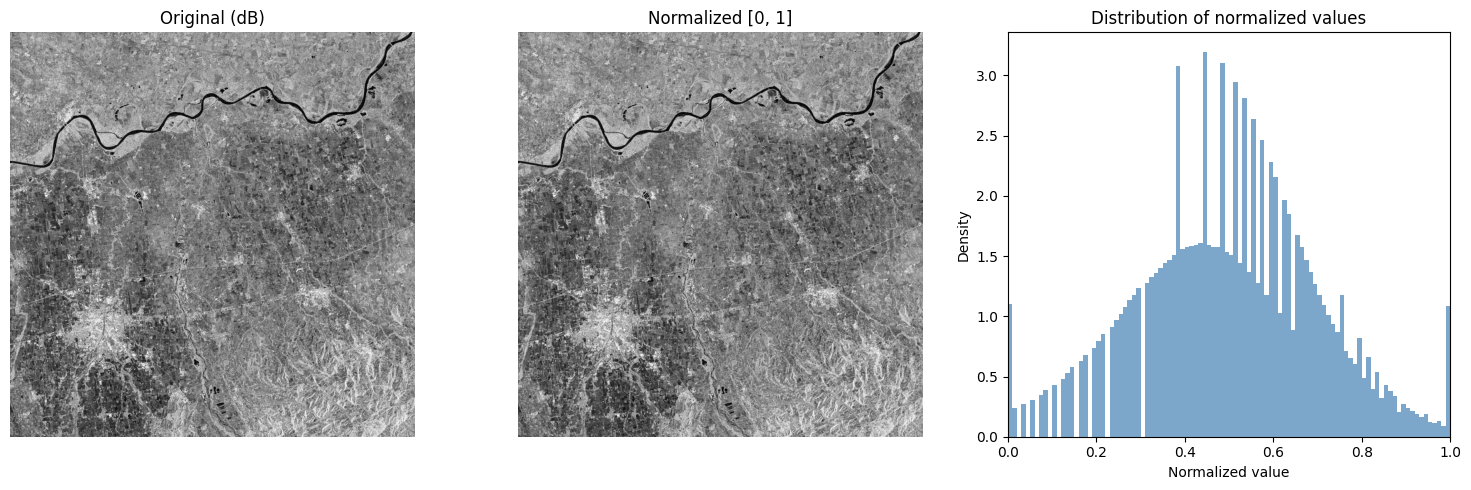

In [24]:
# Visualize preprocessing effect
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original (dB, percentile stretch)
image_db = 10 * np.log10(np.maximum(image_cropped, 1e-10))
axes[0].imshow(image_db, cmap='gray', vmin=params['vmin'], vmax=params['vmax'])
axes[0].set_title('Original (dB)')
axes[0].axis('off')

# Normalized
axes[1].imshow(normalized, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Normalized [0, 1]')
axes[1].axis('off')

# Histogram of normalized values
axes[2].hist(normalized.flatten(), bins=100, density=True, alpha=0.7, color='steelblue')
axes[2].set_xlabel('Normalized value')
axes[2].set_ylabel('Density')
axes[2].set_title('Distribution of normalized values')
axes[2].set_xlim([0, 1])

plt.tight_layout()
plt.show()
plt.close(fig)

In [25]:
zero_fraction = np.mean(normalized == 0)
print(f"Fraction of zero pixels: {zero_fraction:.2%}")

Fraction of zero pixels: 1.10%


---

# Part 4: Speckle Analysis (30 minutes)

Deep dive into speckle statistics and simulation.

## 4.1 Simulate Speckle Noise

In [26]:
def simulate_speckle(clean_image, num_looks=4):
    """
    Simulate multiplicative speckle noise.
    
    For L-look data, speckle follows Gamma(L, 1/L) distribution
    with mean = 1 and variance = 1/L.
    
    Args:
        clean_image: "Clean" underlying reflectivity
        num_looks: Number of looks (controls speckle strength)
        
    Returns:
        noisy: Image with multiplicative speckle
    """
    # Generate gamma-distributed speckle with mean=1, variance=1/L
    speckle = np.random.gamma(
        shape=num_looks, 
        scale=1/num_looks, 
        size=clean_image.shape
    )
    
    # Apply multiplicatively
    noisy = clean_image * speckle
    
    return noisy

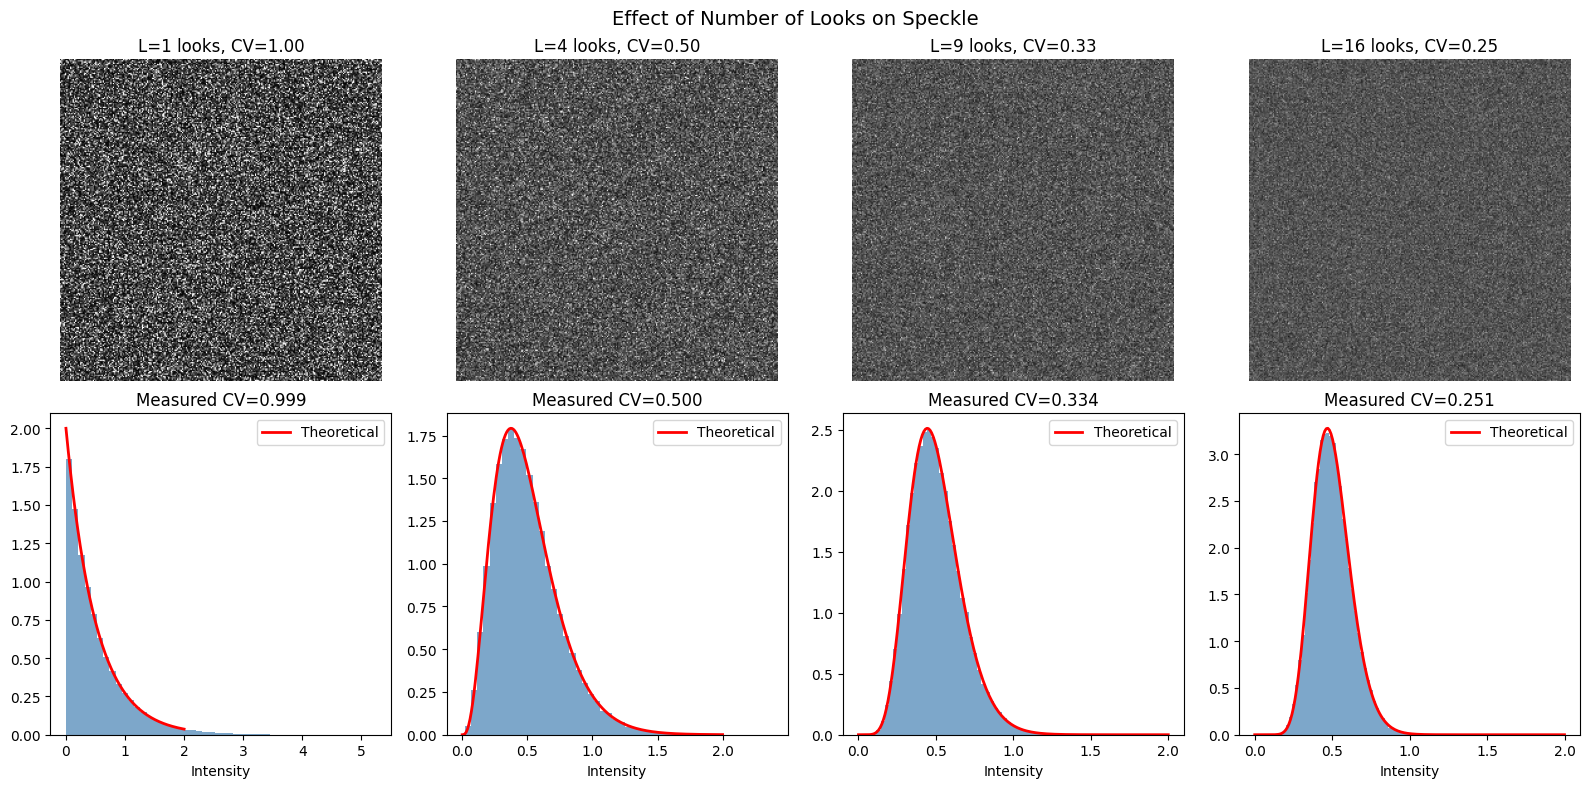

In [27]:
# Create a clean test image
clean_test = np.ones((256, 256)) * 0.5  # Uniform reflectivity

# Simulate different numbers of looks
looks_values = [1, 4, 9, 16]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, L in enumerate(looks_values):
    noisy = simulate_speckle(clean_test, num_looks=L)
    
    # Image
    axes[0, idx].imshow(noisy, cmap='gray', vmin=0, vmax=1.5)
    axes[0, idx].set_title(f'L={L} looks, CV={1/np.sqrt(L):.2f}')
    axes[0, idx].axis('off')
    
    # Histogram
    axes[1, idx].hist(noisy.flatten(), bins=50, density=True, alpha=0.7, color='steelblue')
    
    # Theoretical distribution
    x = np.linspace(0, 2, 200)
    theoretical = gamma_dist.pdf(x, a=L, scale=0.5/L)  # Scale by mean
    axes[1, idx].plot(x, theoretical, 'r-', linewidth=2, label='Theoretical')
    
    measured_cv = noisy.std() / noisy.mean()
    axes[1, idx].set_title(f'Measured CV={measured_cv:.3f}')
    axes[1, idx].set_xlabel('Intensity')
    axes[1, idx].legend()

plt.suptitle('Effect of Number of Looks on Speckle', fontsize=14)
plt.tight_layout()
plt.show()

## 4.2 Verify Speckle Statistics

In [28]:
def analyze_speckle_statistics(image, num_looks_expected=4):
    """
    Verify speckle statistics match theory for homogeneous regions.
    
    For homogeneous regions:
    - CV should be approximately 1/sqrt(L)
    - Intensity histogram should follow gamma distribution
    """
    # Find homogeneous regions using local CV
    local_cv = compute_local_cv(image, window_size=16)
    
    # Homogeneous regions have CV close to theoretical
    theoretical_cv = 1 / np.sqrt(num_looks_expected)
    cv_tolerance = 0.2
    homogeneous_mask = np.abs(local_cv - theoretical_cv) < cv_tolerance
    
    # Also exclude very bright/dark regions
    intensity_mask = (image > np.percentile(image, 10)) & (image < np.percentile(image, 90))
    homogeneous_mask &= intensity_mask
    
    # Extract homogeneous pixels
    homogeneous_pixels = image[homogeneous_mask]
    
    if len(homogeneous_pixels) < 1000:
        print("Warning: Few homogeneous pixels found")
        return None
    
    # Normalize to mean = 1 for comparison with standard gamma
    mean_val = np.mean(homogeneous_pixels)
    normalized_pixels = homogeneous_pixels / mean_val
    
    # Estimate L from variance
    var_val = np.var(normalized_pixels)
    estimated_L = 1 / var_val
    
    print(f"Speckle Analysis:")
    print(f"  Homogeneous pixels: {len(homogeneous_pixels):,} ({100*homogeneous_mask.mean():.1f}%)")
    print(f"  Measured CV: {np.std(homogeneous_pixels)/np.mean(homogeneous_pixels):.3f}")
    print(f"  Theoretical CV (L={num_looks_expected}): {theoretical_cv:.3f}")
    print(f"  Estimated L from variance: {estimated_L:.2f}")
    
    # Plot histogram vs theoretical distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: histogram with theoretical overlay
    axes[0].hist(normalized_pixels, bins=100, density=True, alpha=0.7, 
                 color='steelblue', label='Data')
    
    x = np.linspace(0, 4, 200)
    theoretical_pdf = gamma_dist.pdf(x, a=num_looks_expected, scale=1/num_looks_expected)
    axes[0].plot(x, theoretical_pdf, 'r-', linewidth=2, 
                 label=f'Gamma(L={num_looks_expected})')
    
    estimated_pdf = gamma_dist.pdf(x, a=estimated_L, scale=1/estimated_L)
    axes[0].plot(x, estimated_pdf, 'g--', linewidth=2, 
                 label=f'Gamma(L={estimated_L:.1f})')
    
    axes[0].set_xlabel('Normalized intensity (I/μ)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Speckle Distribution')
    axes[0].legend()
    axes[0].set_xlim([0, 4])
    
    # Right: show homogeneous regions
    axes[1].imshow(homogeneous_mask, cmap='gray')
    axes[1].set_title('Homogeneous regions (white)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('speckle_analysis.png', dpi=150)
    plt.show()
    plt.close(fig)

    return estimated_L

In [29]:
# h, w = image.shape
# crop_size = 4096
# y_start = h // 2 - crop_size // 2
# x_start = w // 2 - crop_size // 2
# n_cropped_image = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
# print(f"Cropped: {n_cropped_image.shape}, uncropped: {image.shape}")

plt.close("all")
import gc
gc.collect()

12809

Speckle Analysis:
  Homogeneous pixels: 5,941,592 (35.4%)
  Measured CV: 0.252
  Theoretical CV (L=4.4): 0.477
  Estimated L from variance: 15.78


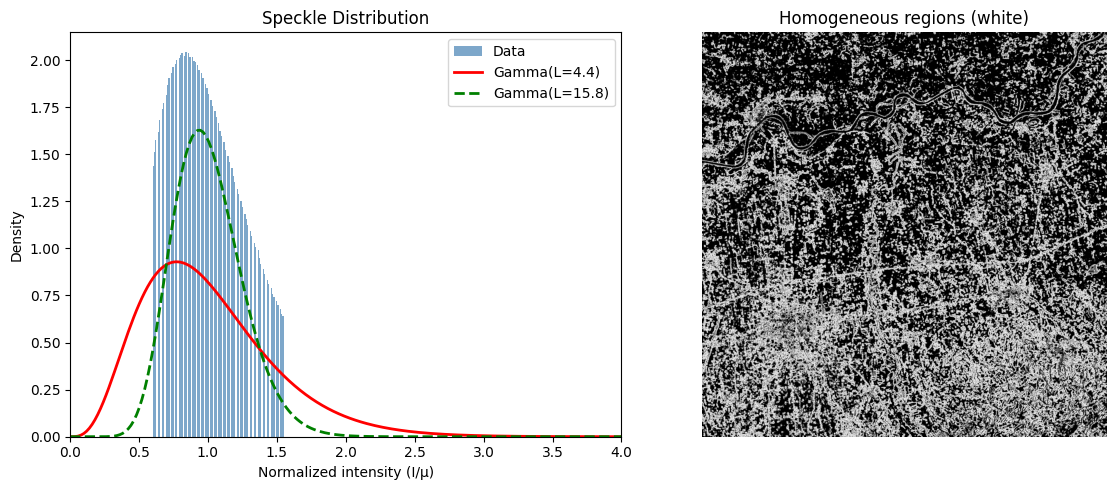

In [30]:
# Analyze speckle in our image
# For synthetic data, we know L=4. For real Sentinel-1 GRD, it's approximately 4.4
expected_looks = 4 if DATA_SOURCE == 'synthetic' else 4.4
estimated_L = analyze_speckle_statistics(image_cropped, num_looks_expected=expected_looks)

In [31]:
threshold = np.percentile(image_cropped, 5)
print(f"Dark threshold: {threshold:.2f}")
print(f"Image mean: {image_cropped.mean():.2f}")

water_mask = image_cropped < threshold


labeled, num_features = ndimage.label(water_mask)
sizes = ndimage.sum(water_mask, labeled, range(1, num_features + 1))
largest = np.argmax(sizes) + 1

# Get coordinates
coords = np.where(labeled == largest)
y_min, y_max = coords[0].min(), coords[0].max()
x_min, x_max = coords[1].min(), coords[1].max()

print(f"Largest dark region: y=[{y_min}:{y_max}], x=[{x_min}:{x_max}]")

# Test it
water_pixels = image_cropped[labeled == largest]
print(f"Water mean: {water_pixels.mean():.2f} (should be << {image_cropped.mean():.2f})")

cv_water = np.std(water_pixels) / np.mean(water_pixels)
L_water = 1 / cv_water**2
print(f"Water CV: {cv_water:.3f}")
print(f"Implied L: {L_water:.1f}")

Dark threshold: 37.00
Image mean: 76.71
Largest dark region: y=[562:1190], x=[572:2534]
Water mean: 27.16 (should be << 76.71)
Water CV: 0.197
Implied L: 25.8


### Speckle Questions

Based on the analysis above:

1. How close is the estimated number of looks to the expected value?
2. Does the histogram match the theoretical gamma distribution well?
3. What might cause deviations from the theoretical distribution?

*Your observations:*



---

# Part 5: Loss Function Implementation (30 minutes)

Implement and understand MSE and SSIM loss functions.

## 5.1 Basic Metrics

In [32]:
def compute_mse(x, x_hat):
    """Mean Squared Error."""
    return np.mean((x - x_hat) ** 2)


def compute_psnr(x, x_hat, data_range=1.0):
    """Peak Signal-to-Noise Ratio in dB."""
    mse = compute_mse(x, x_hat)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(data_range**2 / mse)

## 5.2 Implement SSIM from Scratch

**Exercise:** Implement SSIM following the formula:

$$\text{SSIM}(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

In [ ]:
def compute_ssim_manual(x, x_hat, window_size=11, data_range=1.0):
    """
    Compute Structural Similarity Index (SSIM).
    
    SSIM compares local patches through three factors:
    - Luminance: Are average intensities similar?
    - Contrast: Are intensity variations similar?
    - Structure: Are spatial patterns correlated?

        
    Returns:
        Mean SSIM value
    """
    # Constants (from original SSIM paper)
    K1, K2 = 0.01, 0.03
    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2
    
    # Create uniform averaging window
    window = np.ones((window_size, window_size)) / (window_size ** 2)
    
    # Local means
    mu_x = ndimage.convolve(x, window, mode='reflect')
    mu_y = ndimage.convolve(x_hat, window, mode='reflect')
    
    # Squared means
    mu_x_sq = mu_x ** 2
    mu_y_sq = mu_y ** 2
    mu_xy = mu_x * mu_y
    
    # Local variances: var(X) = E[X²] - E[X]²
    sigma_x_sq = ndimage.convolve(x**2, window, mode='reflect') - mu_x_sq
    sigma_y_sq = ndimage.convolve(x_hat**2, window, mode='reflect') - mu_y_sq
    
    # Local covariance: cov(X,Y) = E[XY] - E[X]E[Y]
    sigma_xy = ndimage.convolve(x * x_hat, window, mode='reflect') - mu_xy
    
    # Ensure non-negative variances (numerical stability)
    sigma_x_sq = np.maximum(sigma_x_sq, 0)
    sigma_y_sq = np.maximum(sigma_y_sq, 0)
    
    # SSIM formula
    numerator = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
    denominator = (mu_x_sq + mu_y_sq + C1) * (sigma_x_sq + sigma_y_sq + C2)
    
    ssim_map = numerator / denominator
    
    return np.mean(ssim_map)

In [34]:
# Verify SSIM implementation
test_img = np.random.rand(64, 64).astype(np.float32)

# SSIM of image with itself should be 1.0
ssim_self = compute_ssim_manual(test_img, test_img)
print(f"SSIM(image, image) = {ssim_self:.6f} (should be 1.0)")

# SSIM with noise should be less than 1
noisy = test_img + np.random.randn(*test_img.shape) * 0.1
noisy = np.clip(noisy, 0, 1)
ssim_noisy = compute_ssim_manual(test_img, noisy)
print(f"SSIM(image, noisy) = {ssim_noisy:.4f}")

SSIM(image, image) = 1.000000 (should be 1.0)
SSIM(image, noisy) = 0.9437


## 5.3 Demonstrate MSE vs SSIM Behavior

In [35]:
def demonstrate_loss_properties():
    """
    Demonstrate when MSE and SSIM disagree.
    
    This illustrates why perceptual metrics like SSIM can better
    match human perception than pixel-wise metrics like MSE.
    """
    # Create test image with sharp edges
    test_img = np.zeros((64, 64), dtype=np.float32)
    test_img[16:48, 16:48] = 1.0  # White square
    
    # Create different types of degradations
    degradations = {}
    
    # 1. Gaussian blur (loses sharpness)
    degradations['blur'] = ndimage.gaussian_filter(test_img, sigma=2)
    
    # 2. Small translation (spatial shift)
    degradations['shift'] = np.roll(np.roll(test_img, 2, axis=0), 2, axis=1)
    
    # 3. Intensity reduction (dimming)
    degradations['dim'] = test_img * 0.7
    
    # 4. Gaussian noise
    degradations['noise'] = np.clip(
        test_img + np.random.normal(0, 0.15, test_img.shape), 0, 1
    ).astype(np.float32)
    
    # 5. Salt and pepper noise
    sp = test_img.copy()
    n_salt = int(0.02 * sp.size)
    salt_coords = [np.random.randint(0, i, n_salt) for i in sp.shape]
    sp[salt_coords[0], salt_coords[1]] = 1
    pepper_coords = [np.random.randint(0, i, n_salt) for i in sp.shape]
    sp[pepper_coords[0], pepper_coords[1]] = 0
    degradations['salt_pepper'] = sp
    
    # Compute metrics
    print("\nLoss Function Comparison:")
    print("-" * 65)
    print(f"{'Degradation':<15} {'MSE':>12} {'PSNR (dB)':>12} {'SSIM':>12}")
    print("-" * 65)
    
    results = {}
    for name, degraded in degradations.items():
        mse = compute_mse(test_img, degraded)
        psnr = compute_psnr(test_img, degraded)
        ssim = compute_ssim_manual(test_img, degraded)
        results[name] = {'mse': mse, 'psnr': psnr, 'ssim': ssim}
        print(f"{name:<15} {mse:>12.4f} {psnr:>12.2f} {ssim:>12.4f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    axes[0].imshow(test_img, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    for idx, (name, degraded) in enumerate(degradations.items(), 1):
        r = results[name]
        axes[idx].imshow(degraded, cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(f'{name}\nMSE={r["mse"]:.3f}, SSIM={r["ssim"]:.3f}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('loss_comparison.png', dpi=150)
    plt.show()
    
    return results


Loss Function Comparison:
-----------------------------------------------------------------
Degradation              MSE    PSNR (dB)         SSIM
-----------------------------------------------------------------
blur                  0.0139        18.55       0.7817
shift                 0.0605        12.18       0.7532
dim                   0.0225        16.48       0.9564
noise                 0.0107        19.70       0.3077
salt_pepper           0.0178        17.49       0.4235


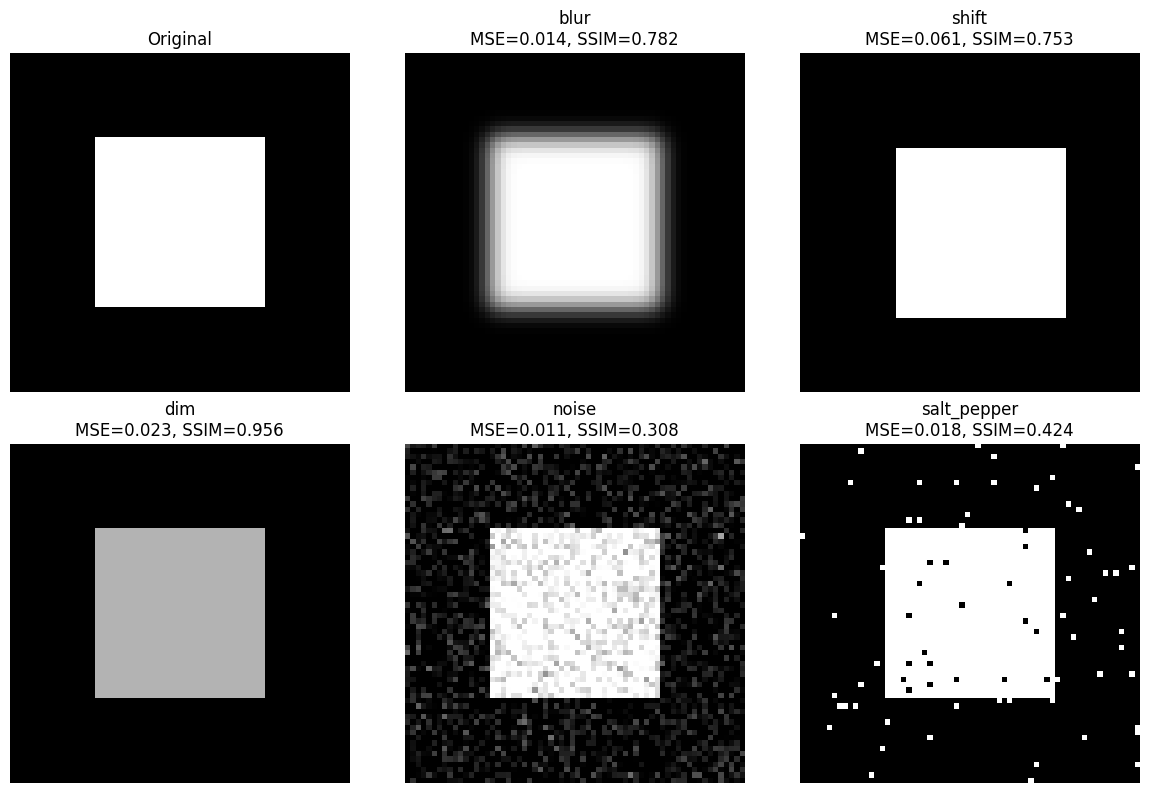

In [36]:
# Run the demonstration
results = demonstrate_loss_properties()

### Loss Function Questions

Look at the results above and answer:

1. Which degradation has the worst MSE? The worst SSIM?
2. Compare 'blur' and 'shift' - which looks more like the original to you? Which metric agrees with your perception?
3. Why might 'shift' have high MSE but relatively high SSIM?

*Your observations:*



---

# Part 6: Integration Test (30 minutes)

Bring everything together and prepare data for Day 2.

## 6.1 Extract Training Patches

In [ ]:
def extract_patches(image, patch_size=256, stride=128, min_valid=0.9):
    """
    Extract patches from normalized image
        
    Returns:
        patches: Array of shape (N, patch_size, patch_size)
        positions: List of (y, x) positions
    """
    patches = []
    positions = []
    
    h, w = image.shape
    
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            
            # Check for valid pixels (not at clip boundaries)
            valid_frac = np.mean((patch > 0.01) & (patch < 0.99))
            
            if valid_frac >= min_valid:
                patches.append(patch)
                positions.append((i, j))
    
    return np.array(patches), positions

In [38]:
# Extract patches from normalized image
patch_size = 256
stride = 128

patches, positions = extract_patches(normalized, patch_size=patch_size, stride=stride)

print(f"Extracted {len(patches)} patches")
print(f"Patch shape: {patches[0].shape}")
print(f"Normalised shape: {normalized.shape}")
print(f"Patches array shape: {patches.shape}")
print(f"\nPatch statistics:")
print(f"  Mean: {patches.mean():.4f}")
print(f"  Std: {patches.std():.4f}")
print(f"  Min: {patches.min():.4f}")
print(f"  Max: {patches.max():.4f}")

Extracted 955 patches
Patch shape: (256, 256)
Normalised shape: (4096, 4096)
Patches array shape: (955, 256, 256)

Patch statistics:
  Mean: 0.4980
  Std: 0.1983
  Min: 0.0000
  Max: 1.0000


In [39]:
def run_complete_pipeline(image_path, project_dir, patch_size, stride):
    print("="*70)
    print("COMPLETE PIPELINE TEST")
    print("="*70)

    print("\n1. Loading SAR image...")
    image = load_sar_image(image_path)
    print(f"Shape: {image.shape}")
    print(f"Data Type: {image.dtype}")

    print("\n2. Analysing Stats...")
    stats = analyze_sar_statistics(image)
    print(f"   Linear mean: {stats['linear']['mean']:.4f}")
    print(f"   Linear range: [{stats['linear']['min']:.6f}, {stats['linear']['max']:.2f}]")
    print(f"   dB mean: {stats['dB']['mean']:.1f}")
    print(f"   dB std: {stats['dB']['std']:.1f}")
    print(f"   Estimated looks: {stats['estimated_looks']:.1f}")
    print(f"   Invalid pixels: {100*stats['invalid_pixel_fraction']:.2f}%")

    visualize_sar_image(image, stats, save_path= (project_root / "data" / "images" / f"sar_{timestamp}_visualisation.png" ))

    print("\n3. Prepocessing beginning...")
    normalised, params = preprocess_sar_complete(image)
    print(f"   Output range: [{normalized.min():.4f}, {normalized.max():.4f}]")
    print(f"   Clip bounds: [{params['vmin']:.1f}, {params['vmax']:.1f}] dB")

    print("\n4. Testing roundtrip...")
    test_preprocessing_roundtrip(image)

    print("\n5. Analyzing speckle statistics...")
    estimated_L = analyze_speckle_statistics(image, num_looks_expected=4.4)

    print("\n6. Extracting Patches...")
    patches = []
    h, w = normalised.shape
    
    for i in range(0, h- patch_size + 1, stride):
        for j in range(0, h - patch_size + 1, stride):
            patch = normalised[i:i+patch_size, j:j+patch_size]
            if patch.min() > 0.01 and patch.max() < 0.99:
                patches.append(patch)

    patches = np.array(patches)
    print(f"   Extracted {len(patches)} valid patches")
    print(f"   Patch shape: {patches[0].shape}")
    print(f"   Patch mean: {patches.mean():.4f}")
    print(f"   Patch std: {patches.std():.4f}")

    print("\n" + "="*70)
    print("PIPELINE COMPLETE")
    print("="*70)

    return patches, params

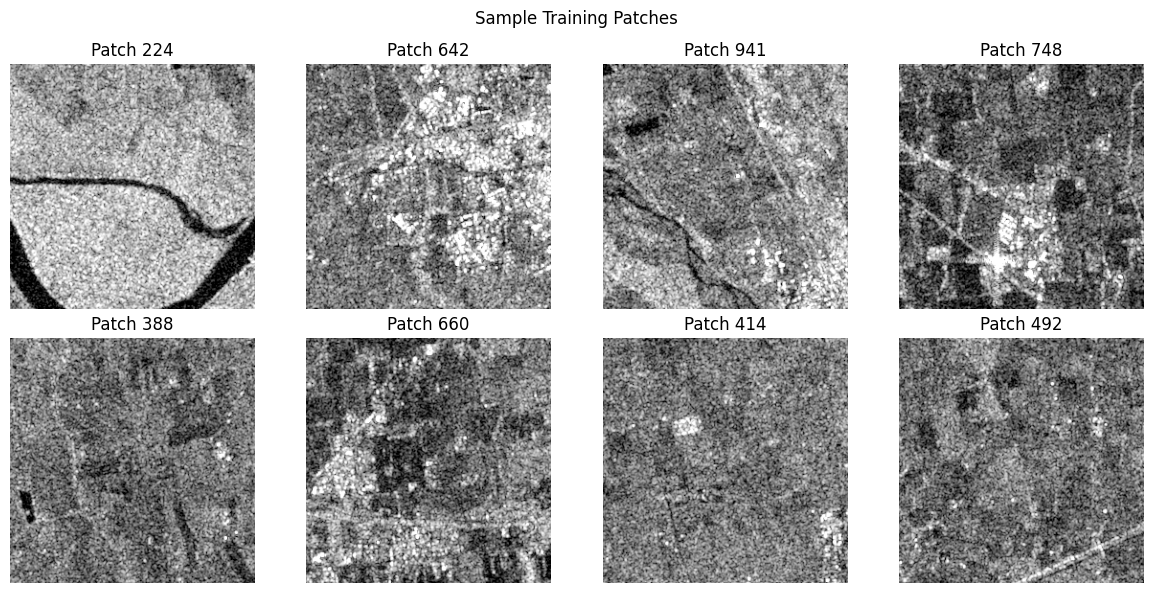

In [40]:
# Visualize some patches
n_show = min(8, len(patches))
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

indices = np.random.choice(len(patches), n_show, replace=False)
for idx, ax in enumerate(axes):
    if idx < n_show:
        ax.imshow(patches[indices[idx]], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Patch {indices[idx]}')
    ax.axis('off')

plt.suptitle('Sample Training Patches')
plt.tight_layout()
plt.show()

## 6.2 Save Data for Day 2

In [42]:
# Save patches and preprocessing parameters
output_dir = Path("D:/Projects/CNNAutoencoderProject/data/patches")
output_dir.mkdir(exist_ok=True)

# Save patches
np.save(output_dir / 'patches.npy', patches)
print(f"Saved {len(patches)} patches to {output_dir / 'patches.npy'}")

# Save preprocessing parameters (excluding the large mask)
params_to_save = {
    'vmin': params['vmin'],
    'vmax': params['vmax'],
}
np.save(output_dir / 'preprocess_params.npy', params_to_save)
print(f"Saved preprocessing parameters to {output_dir / 'preprocess_params.npy'}")

# Save statistics for reference
np.save(output_dir / 'statistics.npy', stats)
print(f"Saved statistics to {output_dir / 'statistics.npy'}")

Saved 955 patches to D:\Projects\CNNAutoencoderProject\data\patches\patches.npy
Saved preprocessing parameters to D:\Projects\CNNAutoencoderProject\data\patches\preprocess_params.npy
Saved statistics to D:\Projects\CNNAutoencoderProject\data\patches\statistics.npy


---

# Day 1 Checklist

Before proceeding to Day 2, verify you have completed:

- [ ] All 5 theory questions answered with complete explanations
- [ ] SAR image loaded and statistics analyzed
- [ ] Visualizations created and interpreted
- [ ] Local CV computation implemented and tested
- [ ] Preprocessing pipeline implemented and roundtrip verified
- [ ] Speckle statistics analyzed and compared to theory
- [ ] SSIM implemented from scratch
- [ ] MSE vs SSIM behavior understood
- [ ] Patches extracted and saved for Day 2

**If any items are incomplete, review the corresponding material before proceeding.**

In [ ]:
print("="*70)
print("DAY 1 COMPLETE")
print("="*70)
print(f"""
Summary:
- Processed image: {image.shape}
- Extracted patches: {len(patches)}
- Preprocessing bounds: [{params['vmin']:.1f}, {params['vmax']:.1f}] dB
- Estimated looks: {stats['estimated_looks']:.1f}

Files saved to: {output_dir.absolute()}
- patches.npy
- preprocess_params.npy  
- statistics.npy

Ready for Day 2: Model Architecture Implementation
""")

DAY 1 COMPLETE

Summary:
- Processed image: (16704, 26101)
- Extracted patches: 955
- Preprocessing bounds: [14.3, 22.6] dB
- Estimated looks: 3.7

Files saved to: D:\Projects\CNNAutoencoderProject\data\patches
- patches.npy
- preprocess_params.npy  
- statistics.npy

Ready for Day 2: Model Architecture Implementation

